In [2]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csc_matrix
import numpy as np
import anndata as ad
from tqdm import tqdm
from scipy.sparse import lil_matrix, hstack

In [3]:
adata_lung= sc.read_h5ad("dataset/lung_cell_atlas.h5ad", backed='r')

In [4]:
adata_lung

AnnData object with n_obs × n_vars = 2282447 × 56239 backed at 'dataset/lung_cell_atlas.h5ad'
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subj

In [ ]:
# read tsv file with gene names
genes_list = pd.read_csv("OS_scRNA_gene_index.19264.tsv", header=None, sep="\t")[0].tolist()

In [ ]:
adata_lung.var

In [ ]:
len(genes_list)

In [ ]:
new_var = pd.DataFrame(index=genes_list)
original_var_indexed = adata_lung.var.set_index('original_gene_symbols')
new_var = new_var.join(original_var_indexed)

In [ ]:
original_gene_positions = pd.Series(
    range(adata_lung.n_vars),
    index=adata_lung.var['original_gene_symbols']
)

ordered_indices = original_gene_positions.reindex(genes_list).values

In [ ]:
n_obs = adata_lung.n_obs
n_vars_new = len(genes_list)

new_X = lil_matrix((n_obs, n_vars_new), dtype=np.int32) 

In [ ]:
target_positions = np.where(~np.isnan(ordered_indices))[0]
source_positions = ordered_indices[~np.isnan(ordered_indices)].astype(int)

In [ ]:
new_X[:, target_positions] = adata_lung.layers['soupX'][:, source_positions]

In [ ]:
new_X = new_X.tocsc()

In [ ]:
adata_final_raw = ad.AnnData(X=new_X, obs=adata_lung.obs.copy(), var=new_var)

In [ ]:
# remove cells with gene counts under 200
sc.pp.filter_cells(adata_final_raw, min_genes=200)
print(f"Final dataset shape: {adata_final_raw.shape}")

In [ ]:
adata_final_raw.write_h5ad("dataset/lung_cell_atlas_processed.h5ad")

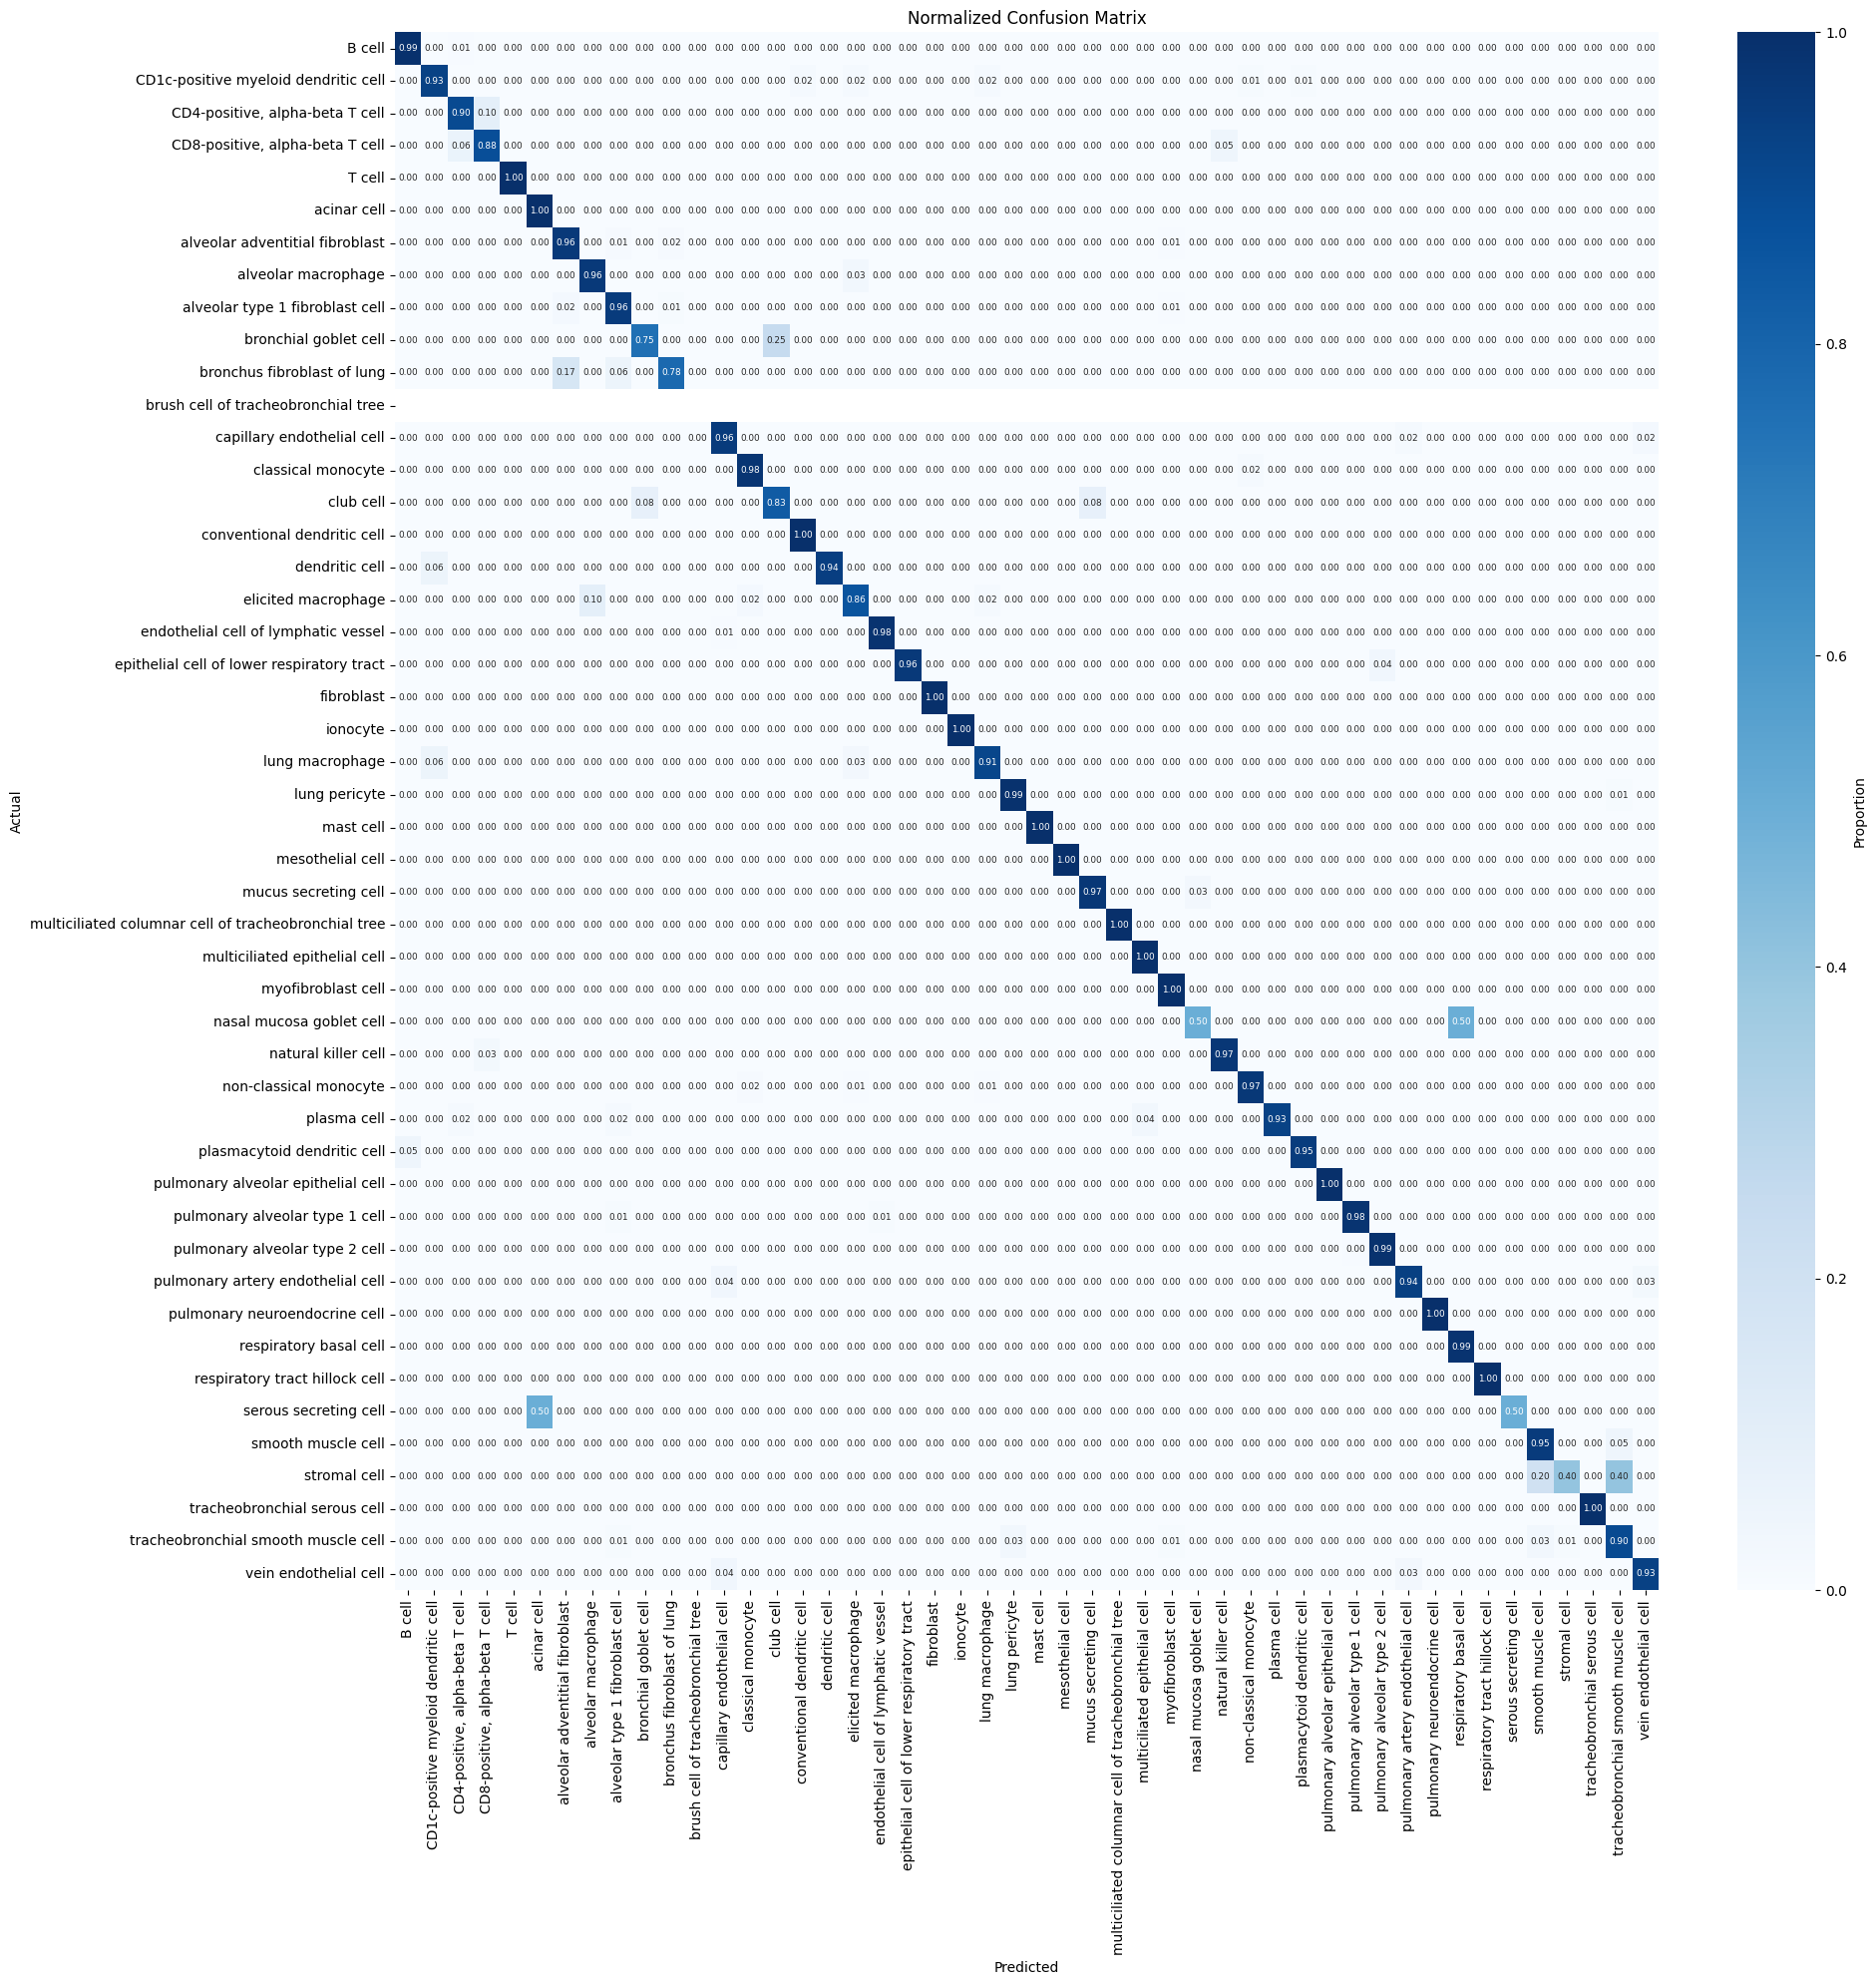

In [ ]:
# import json
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # --- 1. Carica il JSON ---
# with open("conf_mat_table_102_7e55d1667d4853479cde.table.json", "r") as f:
#     data_json = json.load(f)



# # --- 2. Converti in DataFrame ---
# df = pd.DataFrame(data_json['data'], columns=data_json['columns'])

# # --- 3. Pivot per creare matrice quadrata ---
# conf_mat = df.pivot(index="Actual", columns="Predicted", values="nPredictions")
# conf_mat = conf_mat.fillna(0)

# # --- 4. Normalizzazione per riga ---
# conf_mat_normalized = conf_mat.div(conf_mat.sum(axis=1), axis=0)

# num_classes = conf_mat.shape[0]
# annot_font_size = max(4, 12 - math.log(num_classes, 2))  # scala dinamica

# plt.figure(figsize=(20, 20))
# sns.heatmap(
#     conf_mat_normalized,
#     annot=True,
#     fmt=".2f",
#     cmap="Blues",
#     cbar_kws={'label': 'Proportion'},
#     annot_kws={"size": annot_font_size}  # 👈 riduce testo automaticamente
# )
# plt.title("Normalized Confusion Matrix")
# plt.ylabel("Actual")
# plt.xlabel("Predicted")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.savefig("confusion_matrix_normalized_with_labels.pdf", dpi=300)